link to my Github repo: https://github.com/SUN-Wenjun/Advanced_Machine_Learning_Assignment/tree/master/Assignment1

# Assignment 1

We used countries as a categorical variable during our in class mini-hackathon.   This variable actually is categorical at the observation level.  Suffice it to say, in practice we do not really want to build a categorical variable using a variable that has as many categories as it we have observations in our dataset. 

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 0. Merge datasets, add region

Before building your model replace the variable denoting country names with a new variable denoting world regions.  Here is a dataset you can use to merge in this data: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv

In [6]:
data = pd.read_csv("data/worldhappiness2019.csv")

regiondata = pd.read_csv("data/region.csv")


mergedata = pd.merge(data, regiondata, how='left', left_on='Country or region', right_on='name')
# Check for missing values (there won't be any given that I have already cleaned up the region data)
mergedata.loc[pd.isnull(mergedata).iloc[:,9]].to_csv("missing.csv",index=False)

# clean up final region data
X = mergedata.drop(['Happiness_level', 'name', 'Country or region', 'sub-region'],axis=1)

In [7]:
X.head()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region
0,1.340,1.587,0.986,0.596,0.153,0.393,Europe
1,1.383,1.573,0.996,0.592,0.252,0.410,Europe
2,1.488,1.582,1.028,0.603,0.271,0.341,Europe
3,1.380,1.624,1.026,0.591,0.354,0.118,Europe
4,1.396,1.522,0.999,0.557,0.322,0.298,Europe


In [8]:
y = mergedata['Happiness_level']

## 1. Explore bivariate results (Use visualizations!)

Describe any relationships you see between particular features and the target variable

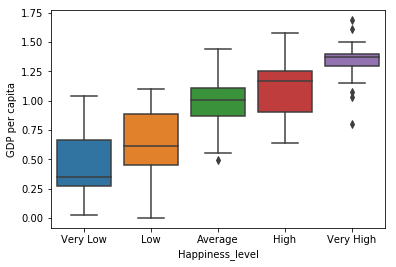

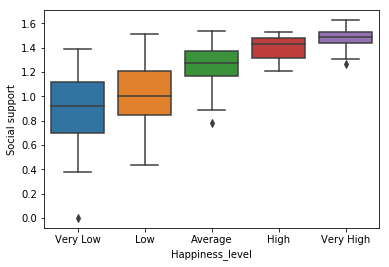

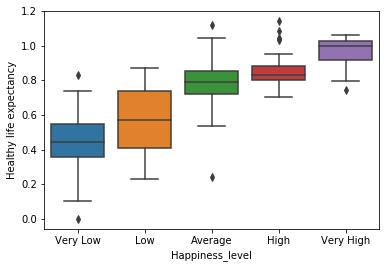

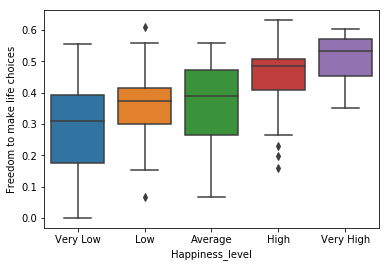

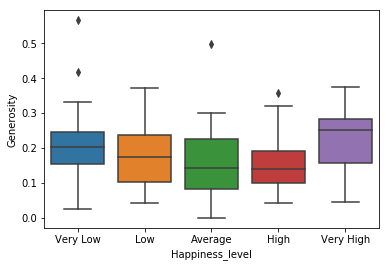

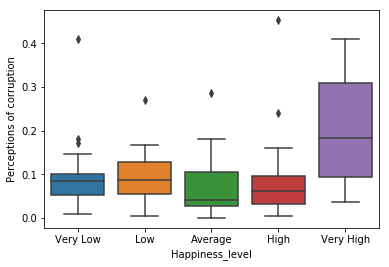

In [75]:
features = ['GDP per capita','Social support', 'Healthy life expectancy','Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
for feature in features:
    ax = sns.boxplot(x='Happiness_level', y=feature, 
                     data=mergedata, 
                     order=['Very Low', 'Low', 'Average', 'High', 'Very High'])
    plt.show()

Answer:

Variables that show a positive correlation with happiness level includes: GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices. In other words, as these variables go higher, happiness level goes higher too.

Generosity and Perceptions of corruption seem to have no clear correlation with happiness level from the box plots. Although it is interesting to find that countries with 'very high' level of happiness show a slightly higher perceptions of corruption, the varietion of this observation is relatively high. 




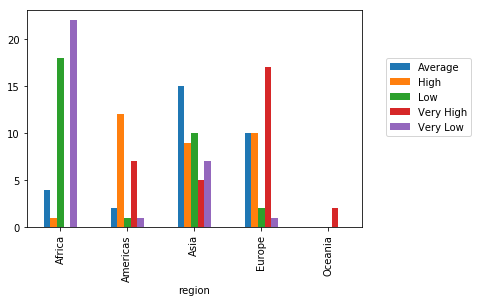

In [74]:
df = pd.crosstab(mergedata['region'], mergedata['Happiness_level'])

ax = df.plot.bar()
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8), ncol=1)

plt.show()

Answer:

When it comes to region, most countries in Europe have 'very high' happiness level, while countries in Africa are more in the range of 'very low' and 'low' level of happiness.

## 2. Examine features that predict happiness categories using one or more models that allow for automatic feature selection

Explain any meaningful findings

### preprocess data

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [76]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#Fit your preprocessor object
prediction_input_preprocessor=preprocessor.fit(X_train) 

import pickle
pickle.dump(prediction_input_preprocessor, open( "preprocessor.pkl", "wb" ) )

### fit a random forest model that allow for feature selection

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [94]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000))
sel.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

Here, SelectFromModel will select the features whose importance is greater than the mean importance of all the features.

In [91]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False])

Answer:

According to the result of feature selection, all the region (dummy) variables are considered less important for predicting happiness level than the average level of all the features.



## 3. Run at least three prediction models to try to predict World Happiness well.

### Model 1

In [101]:
prediction_input_preprocessor.transform(X_train).shape

(117, 11)

In [136]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(124, input_dim=11, activation='relu'))
model.add(Dense(124, activation='relu'))
model.add(Dense(124, activation='relu'))

model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
               batch_size = 60, 
               epochs = 300)  

Epoch 1/300
117/117 [==============================] - 0s 452us/step - loss: 1.6228 - accuracy: 0.1966
Epoch 2/300
117/117 [==============================] - 0s 43us/step - loss: 1.6161 - accuracy: 0.2051
Epoch 3/300
117/117 [==============================] - 0s 43us/step - loss: 1.6095 - accuracy: 0.2564
Epoch 4/300
117/117 [==============================] - 0s 60us/step - loss: 1.6027 - accuracy: 0.2564
Epoch 5/300
117/117 [==============================] - 0s 43us/step - loss: 1.5963 - accuracy: 0.2906
Epoch 6/300
117/117 [==============================] - 0s 34us/step - loss: 1.5895 - accuracy: 0.3077
Epoch 7/300
117/117 [==============================] - 0s 51us/step - loss: 1.5830 - accuracy: 0.3162
Epoch 8/300
117/117 [==============================] - 0s 43us/step - loss: 1.5768 - accuracy: 0.3248
Epoch 9/300
117/117 [==============================] - 0s 43us/step - loss: 1.5705 - accuracy: 0.3419
Epoch 10/300
117/117 [==============================] - 0s 43us/step - loss: 1.56

117/117 [==============================] - 0s 60us/step - loss: 1.2097 - accuracy: 0.5897
Epoch 81/300
117/117 [==============================] - 0s 43us/step - loss: 1.2056 - accuracy: 0.5897
Epoch 82/300
117/117 [==============================] - 0s 68us/step - loss: 1.2014 - accuracy: 0.5897
Epoch 83/300
117/117 [==============================] - 0s 34us/step - loss: 1.1974 - accuracy: 0.5897
Epoch 84/300
117/117 [==============================] - 0s 60us/step - loss: 1.1935 - accuracy: 0.5897
Epoch 85/300
117/117 [==============================] - 0s 43us/step - loss: 1.1893 - accuracy: 0.5897
Epoch 86/300
117/117 [==============================] - 0s 60us/step - loss: 1.1851 - accuracy: 0.5897
Epoch 87/300
117/117 [==============================] - 0s 34us/step - loss: 1.1811 - accuracy: 0.5897
Epoch 88/300
117/117 [==============================] - 0s 51us/step - loss: 1.1771 - accuracy: 0.5897
Epoch 89/300
117/117 [==============================] - 0s 43us/step - loss: 1.1734 - 

117/117 [==============================] - 0s 315us/step - loss: 0.9723 - accuracy: 0.6581
Epoch 159/300
117/117 [==============================] - 0s 43us/step - loss: 0.9700 - accuracy: 0.6581
Epoch 160/300
117/117 [==============================] - 0s 34us/step - loss: 0.9679 - accuracy: 0.6581
Epoch 161/300
117/117 [==============================] - 0s 43us/step - loss: 0.9659 - accuracy: 0.6667
Epoch 162/300
117/117 [==============================] - 0s 51us/step - loss: 0.9637 - accuracy: 0.6581
Epoch 163/300
117/117 [==============================] - 0s 51us/step - loss: 0.9619 - accuracy: 0.6581
Epoch 164/300
117/117 [==============================] - 0s 51us/step - loss: 0.9596 - accuracy: 0.6581
Epoch 165/300
117/117 [==============================] - 0s 102us/step - loss: 0.9577 - accuracy: 0.6581
Epoch 166/300
117/117 [==============================] - 0s 43us/step - loss: 0.9563 - accuracy: 0.6581
Epoch 167/300
117/117 [==============================] - 0s 51us/step - loss

117/117 [==============================] - 0s 43us/step - loss: 0.8458 - accuracy: 0.7094
Epoch 237/300
117/117 [==============================] - 0s 43us/step - loss: 0.8450 - accuracy: 0.7094
Epoch 238/300
117/117 [==============================] - 0s 51us/step - loss: 0.8440 - accuracy: 0.7094
Epoch 239/300
117/117 [==============================] - 0s 60us/step - loss: 0.8428 - accuracy: 0.7265
Epoch 240/300
117/117 [==============================] - ETA: 0s - loss: 0.9184 - accuracy: 0.65 - 0s 43us/step - loss: 0.8411 - accuracy: 0.7179
Epoch 241/300
117/117 [==============================] - 0s 51us/step - loss: 0.8398 - accuracy: 0.7179
Epoch 242/300
117/117 [==============================] - 0s 43us/step - loss: 0.8385 - accuracy: 0.7179
Epoch 243/300
117/117 [==============================] - 0s 51us/step - loss: 0.8376 - accuracy: 0.7265
Epoch 244/300
117/117 [==============================] - 0s 60us/step - loss: 0.8362 - accuracy: 0.7265
Epoch 245/300
117/117 [=============

In [137]:
prediction_index=model.predict_classes(prediction_input_preprocessor.transform(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels,1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

In [138]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro")
        precision_eval = precision_score(y_true, y_pred,average="macro")
        recall_eval = recall_score(y_true, y_pred,average="macro")
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

modelevalobject = model_eval_metrics(y_test, predicted_labels, classification="TRUE")
modelevalobject

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.435897,0.434398,0.44733,0.488571,0,0,0,0


### Model 2

In [139]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(32, input_dim=11, activation='relu')) # change dense to 32
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
               batch_size = 60, 
               epochs = 300)  

Epoch 1/300
117/117 [==============================] - 0s 435us/step - loss: 1.6635 - accuracy: 0.1538
Epoch 2/300
117/117 [==============================] - 0s 34us/step - loss: 1.6567 - accuracy: 0.1624
Epoch 3/300
117/117 [==============================] - 0s 34us/step - loss: 1.6502 - accuracy: 0.1709
Epoch 4/300
117/117 [==============================] - 0s 34us/step - loss: 1.6437 - accuracy: 0.1795
Epoch 5/300
117/117 [==============================] - 0s 34us/step - loss: 1.6372 - accuracy: 0.1795
Epoch 6/300
117/117 [==============================] - 0s 43us/step - loss: 1.6309 - accuracy: 0.1795
Epoch 7/300
117/117 [==============================] - 0s 51us/step - loss: 1.6252 - accuracy: 0.1795
Epoch 8/300
117/117 [==============================] - 0s 34us/step - loss: 1.6187 - accuracy: 0.1709
Epoch 9/300
117/117 [==============================] - 0s 34us/step - loss: 1.6128 - accuracy: 0.1966
Epoch 10/300
117/117 [==============================] - 0s 34us/step - loss: 1.60

117/117 [==============================] - 0s 34us/step - loss: 1.2740 - accuracy: 0.4957
Epoch 81/300
117/117 [==============================] - 0s 43us/step - loss: 1.2700 - accuracy: 0.5043
Epoch 82/300
117/117 [==============================] - 0s 43us/step - loss: 1.2658 - accuracy: 0.5043
Epoch 83/300
117/117 [==============================] - 0s 43us/step - loss: 1.2619 - accuracy: 0.5043
Epoch 84/300
117/117 [==============================] - 0s 34us/step - loss: 1.2577 - accuracy: 0.5043
Epoch 85/300
117/117 [==============================] - 0s 60us/step - loss: 1.2538 - accuracy: 0.4957
Epoch 86/300
117/117 [==============================] - 0s 34us/step - loss: 1.2497 - accuracy: 0.4957
Epoch 87/300
117/117 [==============================] - 0s 43us/step - loss: 1.2460 - accuracy: 0.4957
Epoch 88/300
117/117 [==============================] - 0s 34us/step - loss: 1.2421 - accuracy: 0.4957
Epoch 89/300
117/117 [==============================] - 0s 51us/step - loss: 1.2384 - 

117/117 [==============================] - 0s 34us/step - loss: 1.0451 - accuracy: 0.5556
Epoch 160/300
117/117 [==============================] - 0s 34us/step - loss: 1.0431 - accuracy: 0.5556
Epoch 161/300
117/117 [==============================] - 0s 34us/step - loss: 1.0414 - accuracy: 0.5470
Epoch 162/300
117/117 [==============================] - 0s 34us/step - loss: 1.0397 - accuracy: 0.5470
Epoch 163/300
117/117 [==============================] - 0s 43us/step - loss: 1.0377 - accuracy: 0.5556
Epoch 164/300
117/117 [==============================] - 0s 34us/step - loss: 1.0355 - accuracy: 0.5470
Epoch 165/300
117/117 [==============================] - 0s 43us/step - loss: 1.0335 - accuracy: 0.5470
Epoch 166/300
117/117 [==============================] - 0s 51us/step - loss: 1.0317 - accuracy: 0.5470
Epoch 167/300
117/117 [==============================] - 0s 51us/step - loss: 1.0297 - accuracy: 0.5385
Epoch 168/300
117/117 [==============================] - 0s 43us/step - loss: 

117/117 [==============================] - 0s 34us/step - loss: 0.9233 - accuracy: 0.6325
Epoch 238/300
117/117 [==============================] - 0s 51us/step - loss: 0.9219 - accuracy: 0.6410
Epoch 239/300
117/117 [==============================] - 0s 34us/step - loss: 0.9206 - accuracy: 0.6410
Epoch 240/300
117/117 [==============================] - 0s 51us/step - loss: 0.9194 - accuracy: 0.6325
Epoch 241/300
117/117 [==============================] - 0s 34us/step - loss: 0.9184 - accuracy: 0.6410
Epoch 242/300
117/117 [==============================] - 0s 51us/step - loss: 0.9171 - accuracy: 0.6325
Epoch 243/300
117/117 [==============================] - 0s 43us/step - loss: 0.9157 - accuracy: 0.6410
Epoch 244/300
117/117 [==============================] - 0s 60us/step - loss: 0.9144 - accuracy: 0.6410
Epoch 245/300
117/117 [==============================] - 0s 34us/step - loss: 0.9136 - accuracy: 0.6325
Epoch 246/300
117/117 [==============================] - 0s 43us/step - loss: 

In [140]:
prediction_index=model.predict_classes(prediction_input_preprocessor.transform(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels,1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

In [141]:
modelevalobject = model_eval_metrics(y_test, predicted_labels, classification="TRUE")
modelevalobject

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.461538,0.439635,0.439286,0.48,0,0,0,0


### Model 3

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(32, input_dim=11, activation='relu')) # remove one layer
model.add(Dense(32, activation='relu')) 

model.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
               batch_size = 60, 
               epochs = 300)  

Epoch 1/300
117/117 [==============================] - 0s 366us/step - loss: 1.4942 - accuracy: 0.3590
Epoch 2/300
117/117 [==============================] - 0s 34us/step - loss: 1.4860 - accuracy: 0.3761
Epoch 3/300
117/117 [==============================] - 0s 34us/step - loss: 1.4781 - accuracy: 0.3846
Epoch 4/300
117/117 [==============================] - 0s 34us/step - loss: 1.4698 - accuracy: 0.3846
Epoch 5/300
117/117 [==============================] - 0s 34us/step - loss: 1.4618 - accuracy: 0.3846
Epoch 6/300
117/117 [==============================] - 0s 34us/step - loss: 1.4541 - accuracy: 0.3932
Epoch 7/300
117/117 [==============================] - 0s 60us/step - loss: 1.4466 - accuracy: 0.3846
Epoch 8/300
117/117 [==============================] - 0s 34us/step - loss: 1.4387 - accuracy: 0.4103
Epoch 9/300
117/117 [==============================] - 0s 68us/step - loss: 1.4316 - accuracy: 0.4274
Epoch 10/300
117/117 [==============================] - 0s 43us/step - loss: 1.42

117/117 [==============================] - 0s 34us/step - loss: 1.0941 - accuracy: 0.5897
Epoch 81/300
117/117 [==============================] - 0s 51us/step - loss: 1.0911 - accuracy: 0.5897
Epoch 82/300
117/117 [==============================] - 0s 34us/step - loss: 1.0881 - accuracy: 0.5897
Epoch 83/300
117/117 [==============================] - 0s 43us/step - loss: 1.0855 - accuracy: 0.5983
Epoch 84/300
117/117 [==============================] - 0s 34us/step - loss: 1.0824 - accuracy: 0.5983
Epoch 85/300
117/117 [==============================] - 0s 34us/step - loss: 1.0796 - accuracy: 0.5983
Epoch 86/300
117/117 [==============================] - 0s 68us/step - loss: 1.0767 - accuracy: 0.5983
Epoch 87/300
117/117 [==============================] - 0s 85us/step - loss: 1.0737 - accuracy: 0.5983
Epoch 88/300
117/117 [==============================] - 0s 34us/step - loss: 1.0709 - accuracy: 0.5983
Epoch 89/300
117/117 [==============================] - 0s 68us/step - loss: 1.0683 - 

117/117 [==============================] - 0s 34us/step - loss: 0.9398 - accuracy: 0.6239
Epoch 159/300
117/117 [==============================] - 0s 43us/step - loss: 0.9386 - accuracy: 0.6239
Epoch 160/300
117/117 [==============================] - 0s 43us/step - loss: 0.9371 - accuracy: 0.6239
Epoch 161/300
117/117 [==============================] - 0s 43us/step - loss: 0.9357 - accuracy: 0.6239
Epoch 162/300
117/117 [==============================] - 0s 43us/step - loss: 0.9345 - accuracy: 0.6239
Epoch 163/300
117/117 [==============================] - 0s 34us/step - loss: 0.9333 - accuracy: 0.6325
Epoch 164/300
117/117 [==============================] - 0s 43us/step - loss: 0.9321 - accuracy: 0.6325
Epoch 165/300
117/117 [==============================] - 0s 34us/step - loss: 0.9310 - accuracy: 0.6325
Epoch 166/300
117/117 [==============================] - 0s 34us/step - loss: 0.9296 - accuracy: 0.6325
Epoch 167/300
117/117 [==============================] - 0s 43us/step - loss: 

117/117 [==============================] - 0s 34us/step - loss: 0.8621 - accuracy: 0.6667
Epoch 237/300
117/117 [==============================] - 0s 34us/step - loss: 0.8613 - accuracy: 0.6752
Epoch 238/300
117/117 [==============================] - 0s 43us/step - loss: 0.8601 - accuracy: 0.6667
Epoch 239/300
117/117 [==============================] - 0s 26us/step - loss: 0.8594 - accuracy: 0.6752
Epoch 240/300
117/117 [==============================] - 0s 34us/step - loss: 0.8589 - accuracy: 0.6752
Epoch 241/300
117/117 [==============================] - 0s 34us/step - loss: 0.8581 - accuracy: 0.6752
Epoch 242/300
117/117 [==============================] - 0s 34us/step - loss: 0.8573 - accuracy: 0.6752
Epoch 243/300
117/117 [==============================] - 0s 43us/step - loss: 0.8565 - accuracy: 0.6667
Epoch 244/300
117/117 [==============================] - 0s 34us/step - loss: 0.8555 - accuracy: 0.6752
Epoch 245/300
117/117 [==============================] - 0s 119us/step - loss:

In [143]:
prediction_index=model.predict_classes(prediction_input_preprocessor.transform(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels,1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

In [144]:
modelevalobject = model_eval_metrics(y_test, predicted_labels, classification="TRUE")
modelevalobject

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.538462,0.536111,0.569084,0.588571,0,0,0,0


### 3.1 Discuss which models performed better and point out relevant hyper-parameter values for successful models.

The last model (model 3) performed best among all candidates. 

It is a neural network model with two hidden layers, each of which has 32 nodes. 

I think the reason why it performed better than the other two models is because it's simpler. Given we do not have many input data and the task is relatively simple, a complex model tend to suffer from overfitting. 

### 3.2 Submit your best model to the leader board for the World Happiness AI Model Share competition.

You have the option to discuss these models in your report, but it is not required.

Answer:

I submitted the best model to AI Model Share competition.

In [160]:
import os

if not os.path.exists('mymodel.onnx'):
    from keras2onnx import convert_keras
    onx = convert_keras(model, 'mymodel.onnx')
    with open("mymodel.onnx", "wb") as f:
        f.write(onx.SerializeToString())

Can't import tf2onnx module, so the conversion on a model with any custom/lambda layer will fail!
The maximum opset needed by this model is only 9.


In [152]:
# Loading AWS keys necessary to submit model.  Loading to object, so we don't print them out in our notebook
aws_key_password_region = pickle.load(open( "data/worldhappiness_modelsubmission_keys.pkl", "rb" ) ) 

In [154]:
# Example Model Pre-launched into Model Share Site
apiurl="https://btuvanmi55.execute-api.us-east-1.amazonaws.com/prod/m"
username = # removed when commit to github
password = # removed when commit to github

region='us-east-1'
model_filepath="mymodel.onnx"   
preprocessor_filepath="preprocessor.pkl"
preprocessor="TRUE"

trainingdata=X_train

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

aws_key_password_region = pickle.load( open( "data/worldhappiness_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [161]:
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata=trainingdata,preprocessor_filepath=preprocessor_filepath,preprocessor=preprocessor)

"mymodel.onnx" has been loaded to version 71 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [162]:
leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

LEADERBOARD RANKINGS:


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression
31,0.717949,0.713796,0.719444,0.725000,0,0,0,0,3scman,70,1.666667,1.0
67,0.666667,0.675975,0.754286,0.700952,0,0,0,0,dhoward97,69,2.333333,1.0
32,0.692308,0.693333,0.700397,0.702778,0,0,0,0,3scman,62,3.000000,1.0
41,0.641026,0.646886,0.738333,0.680952,0,0,0,0,dhoward97,68,3.333333,1.0
9,0.589744,0.594805,0.714286,0.640952,0,0,0,0,dhoward97,67,4.666667,1.0
12,0.512821,0.508060,0.625909,0.544444,0,0,0,0,Yihui_Wang,19,6.000000,1.0
36,0.512821,0.504464,0.604242,0.544444,0,0,0,0,Paarth_Malkan,37,7.000000,1.0
27,0.487179,0.482925,0.605195,0.511111,0,0,0,0,bavilaa,21,7.333333,1.0
20,0.487179,0.482925,0.605195,0.511111,0,0,0,0,bavilaa,20,7.333333,1.0
37,0.487179,0.482559,0.576623,0.511111,0,0,0,0,yaowang126,46,8.666667,1.0
